<a href="https://colab.research.google.com/github/Pengyu-gis/MapText/blob/main/TrOCR_finetuning/TrOCR_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive & Prepare Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/MapText/train.zip -d maptext_data
!unzip /content/drive/MyDrive/MapText/val.zip -d maptext_data

In [ ]:
!wget "https://zenodo.org/records/10656556/files/rumsey_train.json?download=1" -O rumsey_train.json
!wget "https://zenodo.org/records/10656556/files/rumsey_val.json?download=1" -O rumsey_val.json


## Load and Parse the JSON Data:

Create a custom dataset class that can parse JSON file and load the corresponding images

In [ ]:
import json
import os
from PIL import Image, ImageDraw
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image, ImageDraw
import os
import matplotlib.patches as patches
import matplotlib.pyplot as plt

class CustomTextImageDataset(Dataset):
    def __init__(self, annotations, img_dir, processor, max_target_length=128):
        self.annotations = annotations
        self.img_dir = img_dir
        self.processor = processor
        self.max_target_length = max_target_length
        # Flatten the list to handle multiple groups and words within each image
        self.flat_annotations = [
            (anno['image'], word)
            for anno in annotations
            for group in anno['groups']
            for word in group
        ]

    def __len__(self):
        return len(self.flat_annotations)

    def __getitem__(self, idx):
        image_path, word_info = self.flat_annotations[idx]
        full_image_path = os.path.join(self.img_dir, image_path)
        image = Image.open(full_image_path).convert("RGB")

        # Extract vertices and text
        vertices = word_info['vertices']
        text = word_info['text']

        # Create a mask with the same dimensions as the image
        mask = Image.new('L', (image.width, image.height), 0)
        ImageDraw.Draw(mask).polygon([tuple(vertex) for vertex in vertices], outline=1, fill=255)
        masked_image = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), mask)

        # Optionally, crop the image to the bounding box of the polygon to focus on the text area
        min_x, min_y = np.min(vertices, axis=0)
        max_x, max_y = np.max(vertices, axis=0)
        cropped_image = masked_image.crop((min_x, min_y, max_x, max_y))

        # Encode the cropped image and text
        encoding = self.processor(cropped_image, return_tensors="pt")
        target_encoding = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length, return_tensors="pt")
        labels = target_encoding.input_ids
        labels[labels == self.processor.tokenizer.pad_token_id] = -100  # Ignore padding in loss computation

        return {"pixel_values": encoding["pixel_values"].squeeze(0), "labels": labels.squeeze(0)}


    def visualize_item(self, idx, ax=None):
        image_path, word_info = self.flat_annotations[idx]
        full_image_path = os.path.join(self.img_dir, image_path)
        image = Image.open(full_image_path).convert("RGB")

        # Extract vertices and text
        vertices = word_info['vertices']
        text = word_info['text']

        # If an axis is not provided, create one
        if ax is None:
            fig, ax = plt.subplots(1)

        # Show the image
        ax.imshow(image)

        # Create a Polygon patch
        poly = patches.Polygon(vertices, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(poly)

        # Add text annotation
        ax.text(vertices[0][0], vertices[0][1], text, color='yellow', fontsize=8)

        plt.show()


In [ ]:
img_dir = "/content/maptext_data/"
max_target_length = 128

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-stage1")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")

In [ ]:
import json

# Load the JSON file
with open('/content/rumsey_train.json', 'r') as f:
    annotations = json.load(f)

# Initialize the dataset
dataset = CustomTextImageDataset(annotations, '/content/maptext_data', processor)

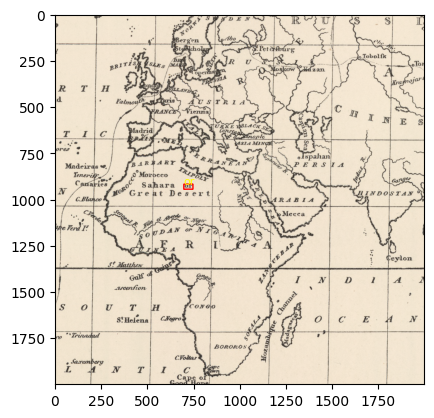

In [ ]:
# Create an instance of the dataset
dataset = CustomTextImageDataset(annotations, img_dir, processor, max_target_length)

# Visualize a specific item by index
dataset.visualize_item(3)  # Replace 0 with the index of the item you want to visualize

In [ ]:
from transformers import XLMRobertaTokenizerFast
tokenizer = XLMRobertaTokenizerFast.from_pretrained("microsoft/trocr-small-stage1")
model.config.pad_token_id = tokenizer.pad_token_id
tokenizer = processor.tokenizer
model.config.decoder_start_token_id = tokenizer.cls_token_id

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=16, shuffle=True,num_workers=2)
# If you have a validation dataset
# val_loader = DataLoader(val_dataset, batch_size=8)
print(len(train_loader))

2158


In [ ]:
some_data = next(iter(train_loader))
print(some_data['pixel_values'].shape, some_data['labels'])

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([2, 3, 384, 384]) tensor([[    0,   791,     5,     2,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100, 

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AdamW
from PIL import Image
import numpy as np
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.cuda.amp import GradScaler, autocast  # Ensure autocast is imported here

model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
model.train()
num_epochs = 1  # Set the number of epochs based on your needs
scaler = GradScaler()  # Initialize the GradScaler

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()

        with autocast():  # Enables mixed precision
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()  # Scales loss for mixed precision
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scale for next iteration
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Average loss for epoch {epoch + 1}: {avg_loss}")

    # Save the model checkpoint after each epoch
    checkpoint_path = f"/content/drive/My Drive/trained_models/training_checkpoint_epoch_{epoch + 1}.pt"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, checkpoint_path)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1:   0%|          | 0/2158 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training Epoch 1: 100%|██████████| 2158/2158 [1:10:48<00:00,  1.30s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training Epoch 1: 100%|██████████| 2158/2158 [1:10:48<00:00,  1.97s/it]


Average loss for epoch 1: 1.3421047593124273


In [ ]:
# Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/MapText2024")
processor.save_pretrained("/content/drive/MyDrive/MapText2024")

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load the model and processor
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/MapText2024")
processor = TrOCRProcessor.from_pretrained("/content/drive/MyDrive/MapText2024")

model.to("cuda")  # If you are using a GPU


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [ ]:
from PIL import Image
import torch

model.to("cuda")

def predict_image(image_path, processor, model):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs.pixel_values.to("cuda")

    with torch.no_grad():
        outputs = model.generate(pixel_values)

    predicted_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    return predicted_text

# Example of zero-shot testing
for i in range(100):
  test_image_path = f"/content/image_{i}.png"
  predicted_text = predict_image(test_image_path, processor, model)
  print("Predicted Text:", predicted_text)